In [1]:
! pip install --upgrade google-cloud-aiplatform google-generativeai langchain langchain-google-genai
! pip install "langchain[docarray]"

## Restart session

In [2]:
import IPython
from IPython.display import display

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
# Define project information
PROJECT_ID = ! gcloud config get-value project
PROJECT_ID = PROJECT_ID[0]
LOCATION = "us-central1" # @param {type:"string"}

# define project information manually if the above code didn't work
if PROJECT_ID == "(unset)":
  PROJECT_ID = "qwiklabs-gcp-01-552593a7017b" # @param {type:"string"}


import vertexai
from vertexai.preview.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)
import langchain
from langchain.llms import VertexAI
from google.cloud import aiplatform


# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=LOCATION)

print(f"LangChain version: {langchain.__version__}")
print(f"Vertex AI SDK version: {aiplatform.__version__}")

LangChain version: 0.1.14
Vertex AI SDK version: 1.46.0


In [2]:
model = GenerativeModel("gemini-pro")

responses = model.generate_content("Tell me a funny joke about dogs?",
                                   stream=True)

for response in responses:
    print(response.text, end="")

What do you call a dog that loves to go to the movies?

A paw-some critic!

## Input an API Key

Create this in you project under APIs and Services | Credentials

In [4]:
import getpass
import os

# getpass will prompt for an API Key
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Provide your Google API Key")


Provide your Google API Key··········


In [6]:
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

llm = ChatGoogleGenerativeAI(model="gemini-pro",
                             temperature=0.7)
result = llm.invoke("Tell me a funny joke about minka kelly")

print(result.content)

Why did Minka Kelly get lost in the woods?

Because she was following a trail of broken hearts.


## A Simple Chain

In [10]:
prompt = ChatPromptTemplate.from_template(
    "tell me a short joke about {topic}"
)

output_parser = StrOutputParser()

chain = prompt | llm | output_parser

chain.invoke({"topic": "actors"})

"Why did the actor get lost on the way to the stage?\n\nBecause he didn't know his cues!"

## RAG with Embeddings

This uses an in-memory Vector Store.

In [11]:
! pip install "langchain[docarray]"

In [21]:

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch


embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# Vector Store takes array of text plpus the embeddings model
# as parameters
vectorstore = DocArrayInMemorySearch.from_texts(
    ["Why did the cat get kicked out of the restaurant? Because it was not well-mannered.",
     "Why did the dog go to the park? To chase squirrels and sniff butts!",
     "Why did the COBOL programmer get lost in the forest? Because he didn’t know how to exit.",
     "Why did the computer science student get a geometry textbook? To improve his algorithms.",
     "Why did the basketball player bring a belt to the game? To hold up his shorts!",
     "Why did the aliens get sent to the principal's office? Because they were from a different planet."
     ],

    embedding=embeddings # passing in the embedder model
)

retriever = vectorstore.as_retriever()


ImportError: Could not import docarray python package. Please install it with `pip install "langchain[docarray]"`.

In [25]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch
! pip uninstall docarray
! pip install docarray


import docarray


embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# Vector Store takes array of text plpus the embeddings model
# as parameters
vectorstore = DocArrayInMemorySearch.from_texts(
    ["Why did the cat get kicked out of the restaurant? Because it was not well-mannered.",
     "Why did the dog go to the park? To chase squirrels and sniff butts!",
     "Why did the COBOL programmer get lost in the forest? Because he didn’t know how to exit.",
     "Why did the computer science student get a geometry textbook? To improve his algorithms.",
     "Why did the basketball player bring a belt to the game? To hold up his shorts!",
     "Why did the aliens get sent to the principal's office? Because they were from a different planet."
     ],

    embedding=embeddings # passing in the embedder model
)

retriever = vectorstore.as_retriever()


Found existing installation: docarray 0.32.1
Uninstalling docarray-0.32.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/docarray-0.32.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/docarray/*
Proceed (Y/n)? Y
  Successfully uninstalled docarray-0.32.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.2/270.2 kB 1.5 MB/s eta 0:00:00


/root/.local/lib/python3.10/site-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [26]:

docs = retriever.get_relevant_documents("Joke about cats", )
print(docs[0].page_content)

Why did the cat get kicked out of the restaurant? Because it was not well-mannered.


In [27]:
docs = retriever.get_relevant_documents("Joke about programming", )
print(docs[0].page_content)

Why did the computer science student get a geometry textbook? To improve his algorithms.


In [28]:
docs = retriever.get_relevant_documents("Tell me a Joke about dogs", )
print(docs[0].page_content)

Why did the dog go to the park? To chase squirrels and sniff butts!


## Multi-Modal

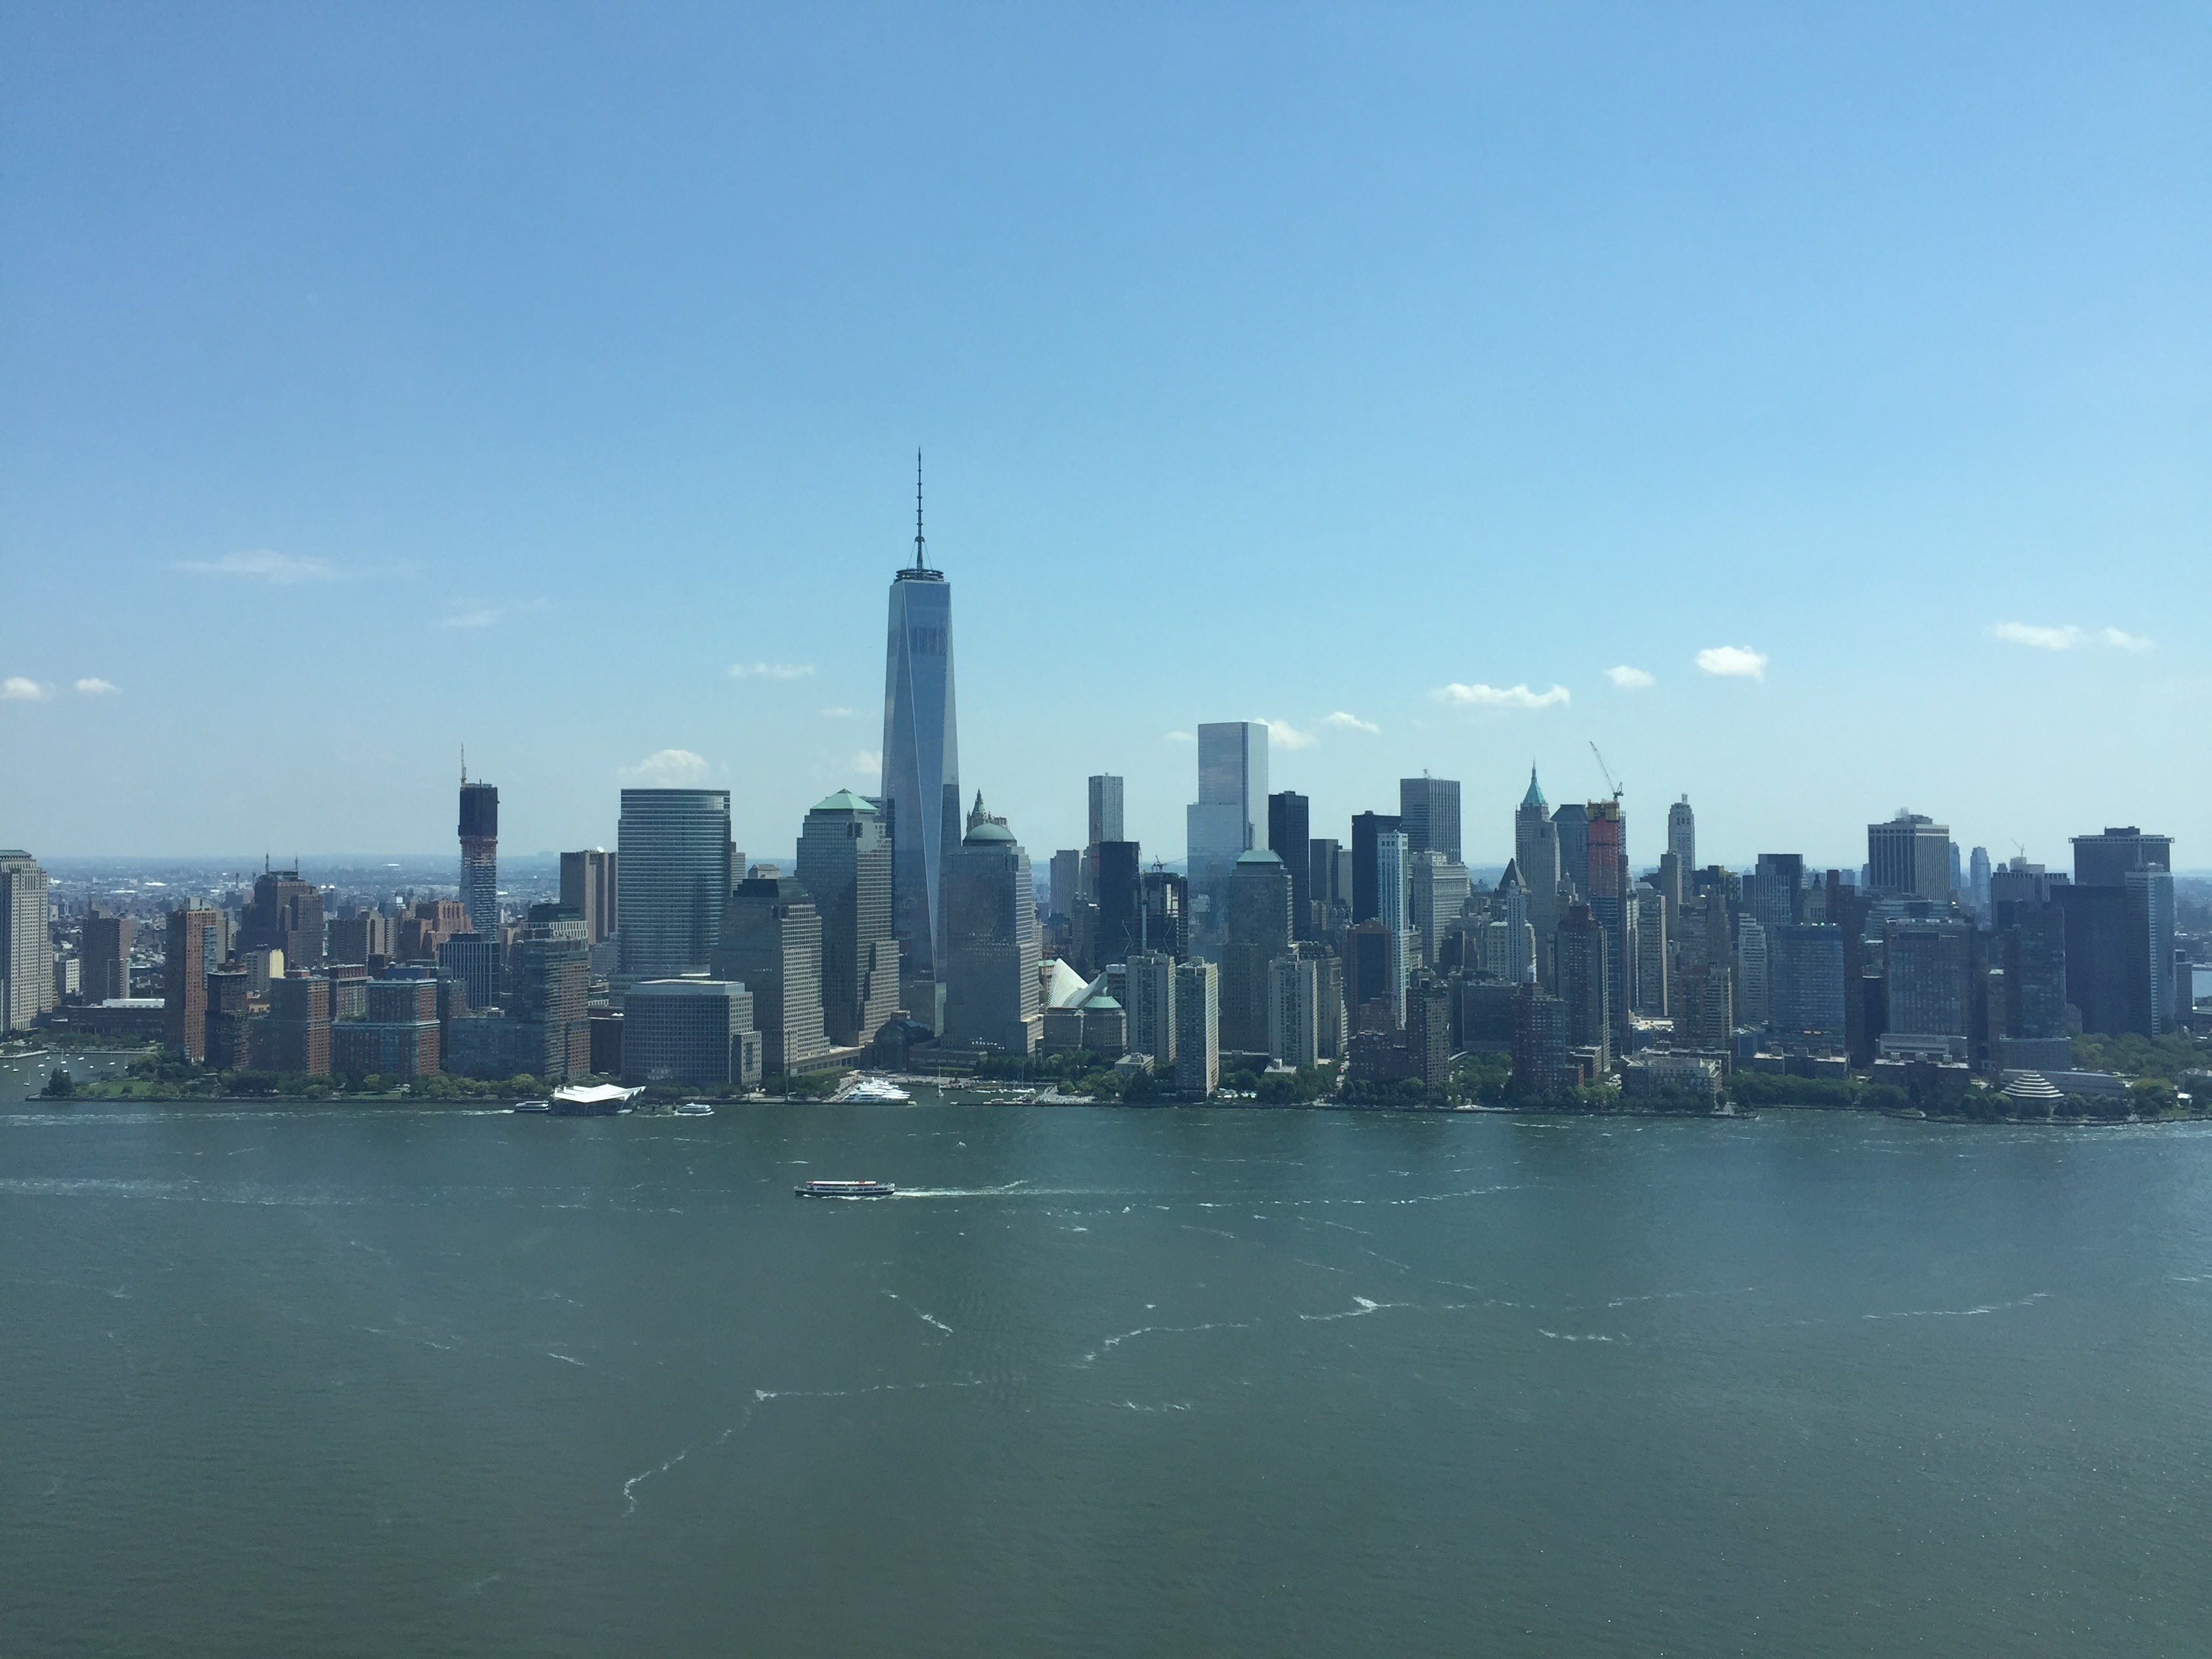

In [29]:
import requests
from IPython.display import Image

image_url = "https://storage.googleapis.com/doug-rehnstrom-public/newyork.JPG"

content = requests.get(image_url).content
Image(content,width=600)



In [30]:
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-pro-vision")

# example
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "What is the location of this picture? Are there and famous landmarks in the picture? How many people live there?",
        },  # You can optionally provide text parts
        {
            "type": "image_url",
            "image_url": image_url
         },
    ]
)

llm.invoke([message])

AIMessage(content=' The picture is of New York City. There are many famous landmarks in the picture including the Statue of Liberty, the Empire State Building, and the Chrysler Building. There are about 8.4 million people living in New York City.', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-fe401b8d-26b4-497a-8f60-03d6579f4834-0')